# decode gsm stream

## setup

In [2]:
%reset -f
import numpy as np
from math import nan,isnan,floor,ceil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import deconvolve,find_peaks
from rtlsdr import RtlSdr
from time import sleep

global pi,i
pi =np.pi
i = np.complex(0,1)

abs2 = lambda x: np.square(np.real(x)) + np.square(np.imag(x))
phase_diff = lambda x: np.gradient(np.imag(x))*np.real(x) - np.real(np.real(x))*np.imag(x)
#phase_diff = lambda x: np.gradient(np.unwrap(np.angle(x)))

## frequencies of local stations

## examples
captured with gnuradio: gr-gsm

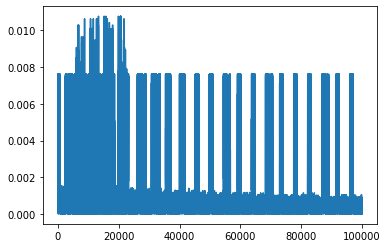

In [3]:
#gsm sequence
samples0 = np.fromfile(open("./gr_gsm_experiments/sequence.iq"), dtype=np.complex)
plt.plot(np.abs(samples0))

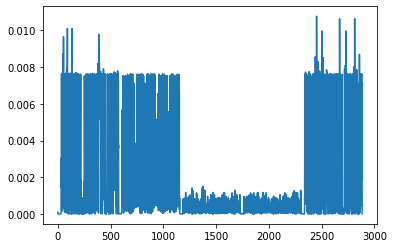

In [4]:
#five gsm bursts
samples1 = np.fromfile(open("./gr_gsm_experiments/5bursts.iq"), dtype=np.complex)
plt.plot(np.abs(samples1))

In [5]:
start = 0
interval = samples1.size

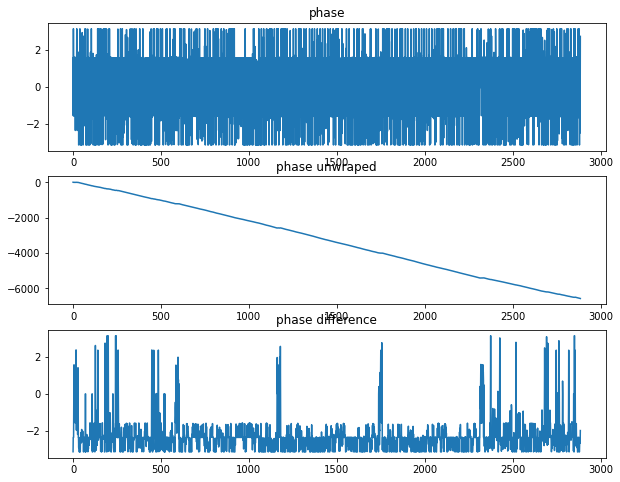

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.title('phase')
plt.plot((np.angle(samples1[start:start+interval])))
plt.subplot(3,1,2)
plt.title('phase unwraped')
plt.plot(np.unwrap(np.angle(samples1[start:start+interval])))
plt.subplot(3,1,3)
plt.title('phase difference')
plt.plot(np.gradient(np.unwrap(np.angle(samples1[start:start+interval]))))

Text(0.5, 0, 'Q')

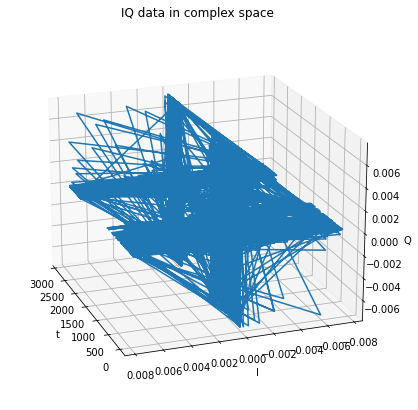

In [7]:
fig = plt.figure(figsize=(17,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(np.arange(interval),np.real(samples1[start:start+interval]),np.imag(samples1[start:start+interval]))
ax.view_init(20, 160)
plt.title('IQ data in complex space')
ax.set_xlabel('t')
ax.set_ylabel('I')
ax.set_zlabel('Q')

## get data

In [354]:
# configure device & capture data
freq = 933.6e+6
sample_rate = 270844.16710001737*5 #1.08e+6 #285e+3 #1.14e+6 #2e+6 #2.28e+6 #2.56e+6
bandwidth = 200e+3
nr_samples = 2**18
time_interval = nr_samples/sample_rate

sdr = RtlSdr()
sleep(1)
sdr.sample_rate = sample_rate
sdr.center_freq = freq
sdr.bandwidth = bandwidth
sdr.freq_correction = 50 #PPM
sdr.gain = 40 #35 #'auto'
samples = sdr.read_samples(nr_samples)
sdr.close()

In [355]:
#gsm burst and capture parameters
burst_time = 576.9e-6 #burst time
burst_symbols = 156.25 #bits per burst
bps = burst_symbols/burst_time #bits per second
sample_per_burst = sample_rate*burst_time
sample_per_bit = sample_per_burst/burst_symbols
print('bits per second: ',bps)
print('time per bit: ',1/bps)
print('samples captured per burst:',sample_per_burst)
print('samples per bit:',sample_per_bit)

bits per second:  270844.16710001737
time per bit:  3.6921599999999997e-06
samples captured per burst: 781.2500000000001
samples per bit: 5.000000000000001


In [358]:
start = 3000
interval = int(sample_per_burst)

a = start
b = start+interval
step = 50
ticks = np.arange(a*1/sample_rate,b*1/sample_rate,step/bps)
labels = [str(i) for i in np.arange(0,len(ticks)*step,step)]
x = np.arange(a,b,1)*1/sample_rate


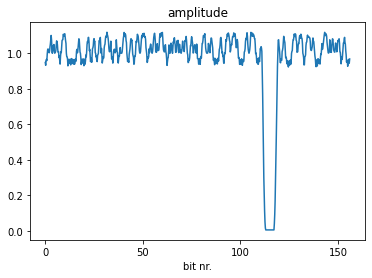

In [359]:
ax = plt.subplot()
plt.title('amplitude')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.plot(x,np.abs(samples[a:b]))
ax.set_xlabel('bit nr.')
plt.show()

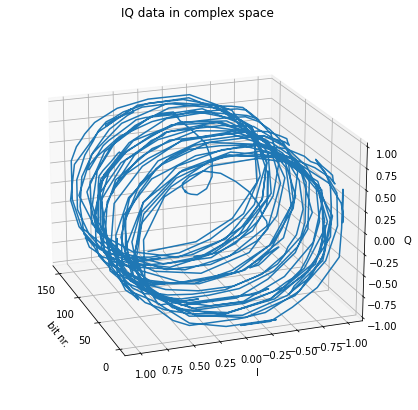

In [360]:
fig = plt.figure(figsize=(17,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,np.real(samples[a:b]),np.imag(samples[a:b]))
ax.view_init(20, 160)
plt.title('IQ data in complex space')
ax.set_xlabel('bit nr.')
ax.set_ylabel('I')
ax.set_zlabel('Q')
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
plt.show()

## extract data

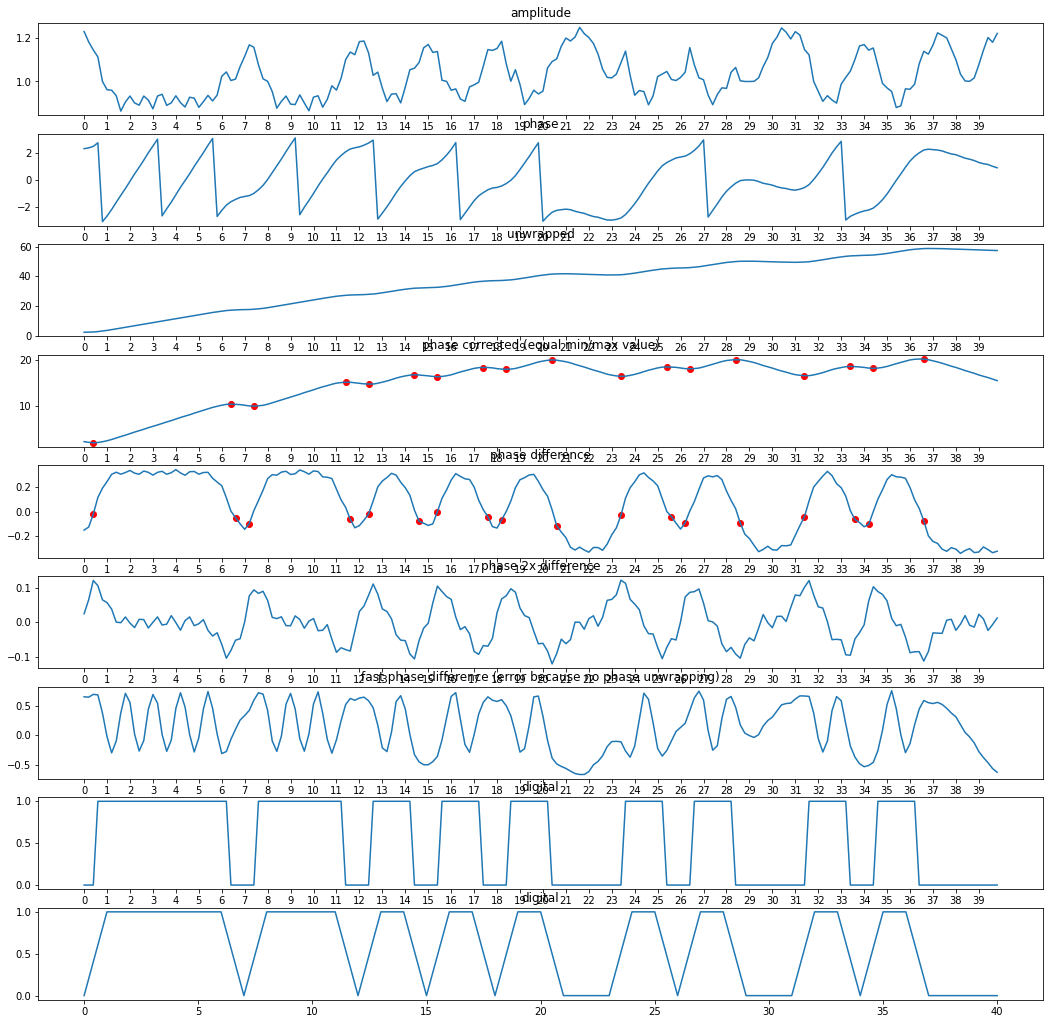

In [437]:

a = start + 50
b = a+200 #a+int(sample_per_burst)
step = 1
ticks = np.arange(a*1/sample_rate,b*1/sample_rate,step/bps)
labels = [str(i) for i in np.arange(0,len(ticks)*step,step)]
x = np.arange(a,b,1)*1/sample_rate

samp = samples[a:b]
ampli = abs2(samp)
phase = np.angle(samp)
unwrap = np.unwrap(phase,discont=pi)

change = np.diff(unwrap)
#smooth = unwrap - (unwrap[-1]-unwrap[1]) * np.arange(0,1,1/np.size(unwrap)) #start = end value
smooth = unwrap - np.arange(b-a)* (change.max() + change.min())/2 #equal max slope
#smooth = gaussian(smooth,0.2)
#smooth = unwrap
data1 = np.gradient(smooth)
data2 = np.gradient(data1)

data3 = phase_diff(samp)

T = 1/bps #time per bit(symbol)
BT=0.3
delta = np.sqrt(np.log(2))/(2*pi*BT)
nn = 15
t = np.arange(-nn/sample_rate,nn/sample_rate,1/sample_rate)
#gauss = np.exp(-t**2/(2*delta**2*T**2))/(np.sqrt(2*pi)*delta*T)
#x[0:2*nn],gauss

digital = data1 > np.sum(data1)/(b-a)

plt.figure(figsize=(18,20))
ax1 = plt.subplot(10,1,1)
plt.title('amplitude')
ax1.plot(x,ampli)
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax2 = plt.subplot(10,1,2)
plt.title('phase')
ax2.plot(x,phase)
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels)
ax3 = plt.subplot(10,1,3)
plt.title('unwrapped')
ax3.plot(x,unwrap)
ax3.set_xticks(ticks)
ax3.set_xticklabels(labels)
ax4 = plt.subplot(10,1,4)
plt.title('phase corrected (equal min/max value)')
ax4.plot(x,smooth)

peak1 = find_peaks(smooth,distance=2*np.ceil(sample_per_bit))[0]
peak2 = find_peaks(-smooth,distance=2*np.ceil(sample_per_bit))[0]
peak = np.unique(np.concatenate((peak1,peak2)))
ax4.scatter(x[peak],smooth[peak],color='red')

ax4.set_xticks(ticks)
ax4.set_xticklabels(labels)
ax5 = plt.subplot(10,1,5)
plt.title('phase difference')
ax5.plot(x,data1)

maxi = np.max(np.abs(data1))*0.2
###find sign change
sign = np.sign(data1)
peak = np.where(np.diff(sign))[0]
ind = data1[peak]>data1[peak+1]
peak = peak+ind
ax5.scatter(x[peak],data1[peak],color='red')

ax5.set_xticks(ticks)
ax5.set_xticklabels(labels)
ax6 = plt.subplot(10,1,6)
plt.title('phase 2x difference')
ax6.plot(x,data2)

'''###find sign change
sign = np.sign(data2)
idx = np.where(np.diff(sign))[0]
idx = np.unique(np.concatenate((idx,idx+1)))
###keep indices whose value is near zero
maxi = np.max(np.abs(data2))*0.2
idx = idx[np.where(np.abs(data2[idx])<maxi)[0]]
###remove zeros with small slope
maxi = np.max(np.abs(data2))*0.05
slp = np.diff(data2)
ind1 = np.where(np.abs(slp[idx-1])>maxi)[0]
ind2 = np.where(np.abs(slp[idx])>maxi)[0]
idx = idx[ind1[np.isin(ind1,ind2)]] #and
#ind = idx[np.unique(np.concatenate((ind1,ind2)))] #or
###remove zeros with distance in samples less then sample_per_bit
ind = np.diff(idx)<sample_per_bit
idx = idx[ np.where(~(ind+np.roll(ind,1)))[0] ]
ax6.scatter(x[idx],data2[idx],color='red')'''

ax6.set_xticks(ticks)
ax6.set_xticklabels(labels)
ax7 = plt.subplot(10,1,7)
plt.title('fast phase difference (error because no phase unwrapping)')
ax7.plot(x,data3)
ax7.set_xticks(ticks)
ax7.set_xticklabels(labels)
ax8 = plt.subplot(10,1,8)
plt.title('digital')
ax8.plot(x,digital)
ax8.set_xticks(ticks)
ax8.set_xticklabels(labels)

bits = np.round( np.diff(np.where(np.diff(digital))[0]) / sample_per_bit ).astype(int)
final = np.zeros(len(ticks)+1)
pos = 1
bit = True
for l in bits:
    final[pos:pos+l] = bit
    bit ^= 1
    pos += l
ax9 = plt.subplot(10,1,9)
plt.title('digital')

ax9.plot(final)

plt.show()

bits:  149
[1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1
 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1
 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1
 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0
 0]


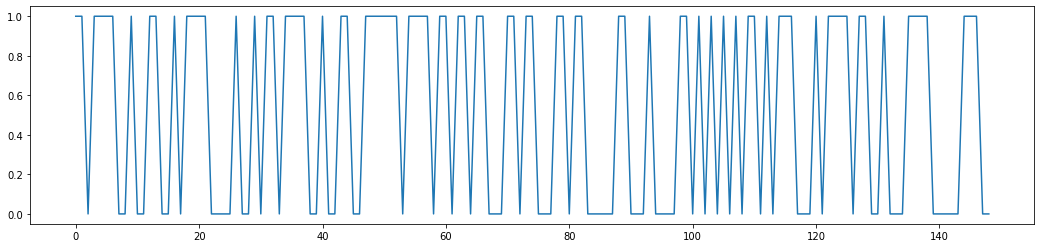

In [484]:

#find power increase of signal (start of burst)
mask = abs2(samples)
mask = mask>np.sum(mask)*0.3/(nr_samples)
start_points_candidate = np.where(np.diff(mask))[0]
ind = (start_points_candidate[1:]-start_points_candidate[:-1])>0.5*sample_per_burst
start_points = list( start_points_candidate[np.where(ind)] )

#extract data
for p in start_points:
    a = p+int(sample_per_bit)
    b = p+int(sample_per_burst)
    #decode
    samp = samples[a:b]
    s = np.argmin(np.diff(abs2(samp)))
    samp = samp[:s]
    phase = np.angle(samp)
    unwrap = np.unwrap(phase,discont=pi)
    slope = np.diff(unwrap)
    smooth = unwrap - s* (slope.max() + slope.min())/2 #equal -min = max slope
    #smooth = gaussian(smooth,0.2)
    phase_change = np.gradient(smooth)
    digital = phase_change > np.sum(phase_change)/(b-a)
    bits = np.round( np.diff(np.where(np.diff(digital))[0]) / sample_per_bit ).astype(int)
    result = np.zeros(np.ceil(s/sample_per_bit).astype(int),dtype=int)
    pos = 0
    bit = True
    for l in bits:
        result[pos:pos+l] = bit
        bit ^= 1
        pos += l
    
    #visualize
    plt.figure(figsize=(18,4))
    plt.plot(result)
    print('bits: ',len(result))
    print(result)
    break

#remaining = samples[p+burst_samples:]

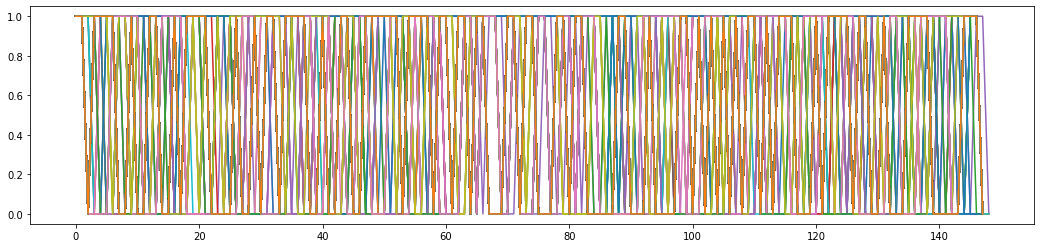

In [480]:

#find power increase of signal (start of burst)
mask = abs2(samples)
mask = mask>np.sum(mask)*0.3/(nr_samples)
start_points_candidate = np.where(np.diff(mask))[0]
ind = (start_points_candidate[1:]-start_points_candidate[:-1])>0.5*sample_per_burst
start_points = list( start_points_candidate[np.where(ind)] )

f = open('gsm.txt','w')

plt.figure(figsize=(18,4))
#extract data
for p in start_points:
    a = p+int(sample_per_bit)
    b = p+int(sample_per_burst)
    #decode
    samp = samples[a:b]
    s = np.argmin(np.diff(abs2(samp)))
    samp = samp[:s]
    phase = np.angle(samp)
    unwrap = np.unwrap(phase,discont=pi)
    slope = np.diff(unwrap)
    smooth = unwrap - s* (slope.max() + slope.min())/2 #equal -min = max slope
    #smooth = gaussian(smooth,0.2)
    phase_change = np.gradient(smooth)
    digital = phase_change > np.sum(phase_change)/(b-a)
    bits = np.round( np.diff(np.where(np.diff(digital))[0]) / sample_per_bit ).astype(int)
    result = np.zeros(np.ceil(s/sample_per_bit).astype(int),dtype=int)
    pos = 0
    bit = True
    for l in bits:
        result[pos:pos+l] = bit
        bit ^= 1
        pos += l
    
    #visualize
    plt.plot(result)
    #print('bits: ',len(result))
    #print(result)
    f.write(str((result)).replace(',','').replace('.','').replace(' ','').replace('\n','').replace('[','').replace(']','')+'\n')

f.close()
#remaining = samples[p+burst_samples:]

## align and read data

#found sequences

11000011111000111100000000011100001111100101001100011001111000011011100100011001101110000000111111100011110001111111001111111110000011000111110011100

11011110010011001011110000100101101111001001100111111011110110110110001101100011011000001100010000110101010101101011100010111101100100011110000011100

...

In [596]:
#reverse/negate sequence
binary = '01011'
print(binary)
print(binary.replace('0','2').replace('1','0').replace('2','1'))
print(binary[::-1])
print(binary[::-1].replace('0','2').replace('1','0').replace('2','1'))

01011
10100
11010
00101


In [589]:
#load byte data
decoded = np.fromfile(open("./gr_gsm_experiments/gsm_demod.txt"), dtype=np.uint8)
decoded_bin = np.unpackbits(decoded)

In [590]:
#bytes to binary
f = open('./gr_gsm_experiments/gsm_demod_bin.txt','w')

for p in decoded_bin:
    f.write(str(p).replace(', ',''))

f.close()